In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("boston.csv")

判断因变量需要进行ln变换

0.2166209012915364


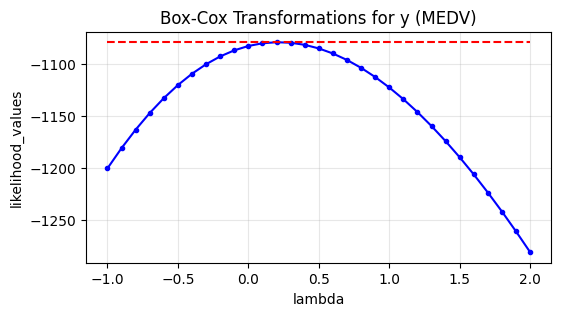

In [3]:
# Box-Cox Transformations for y (Median value of owner-occupied homes in $1000's)
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['MEDV'])
lamb = np.linspace(-1, 2, 31)

likelihood_values = [stats.boxcox_llf(i, df['MEDV']) for i in lamb]
fig = plt.figure(figsize=(6,3))
plt.plot(lamb, likelihood_values, 'b.-')
plt.hlines(max(likelihood_values), -1, 2, colors='red', linestyles='--')
plt.grid(alpha = 0.3)
plt.xlabel('lambda')
plt.ylabel('likelihood_values')
plt.title('Box-Cox Transformations for y (MEDV)')
# plt.vlines(lamb[likelihood_values.index(max(likelihood_values))], -28000, max(likelihood_values))
# plt.ylim(-26000, -10000)
print(fitted_lambda)

In [4]:
df['lnMEDV'] = np.log(df['MEDV'])

In [5]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'lnMEDV'],
      dtype='object')

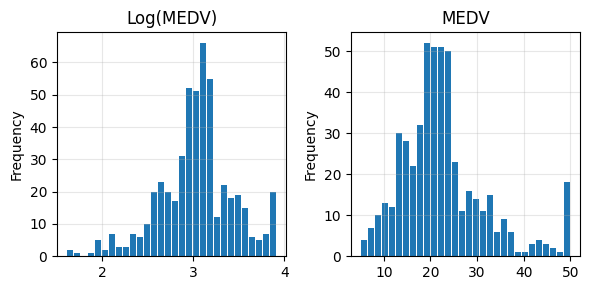

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
df['lnMEDV'].plot.hist(ax = axes[0], title = "Log(MEDV)", rwidth=0.8, bins=30)
axes[0].grid(alpha=0.3)
df['MEDV'].plot.hist(ax = axes[1], title = "MEDV", rwidth=0.8, bins=30)
axes[1].grid(alpha=0.3)
plt.tight_layout()

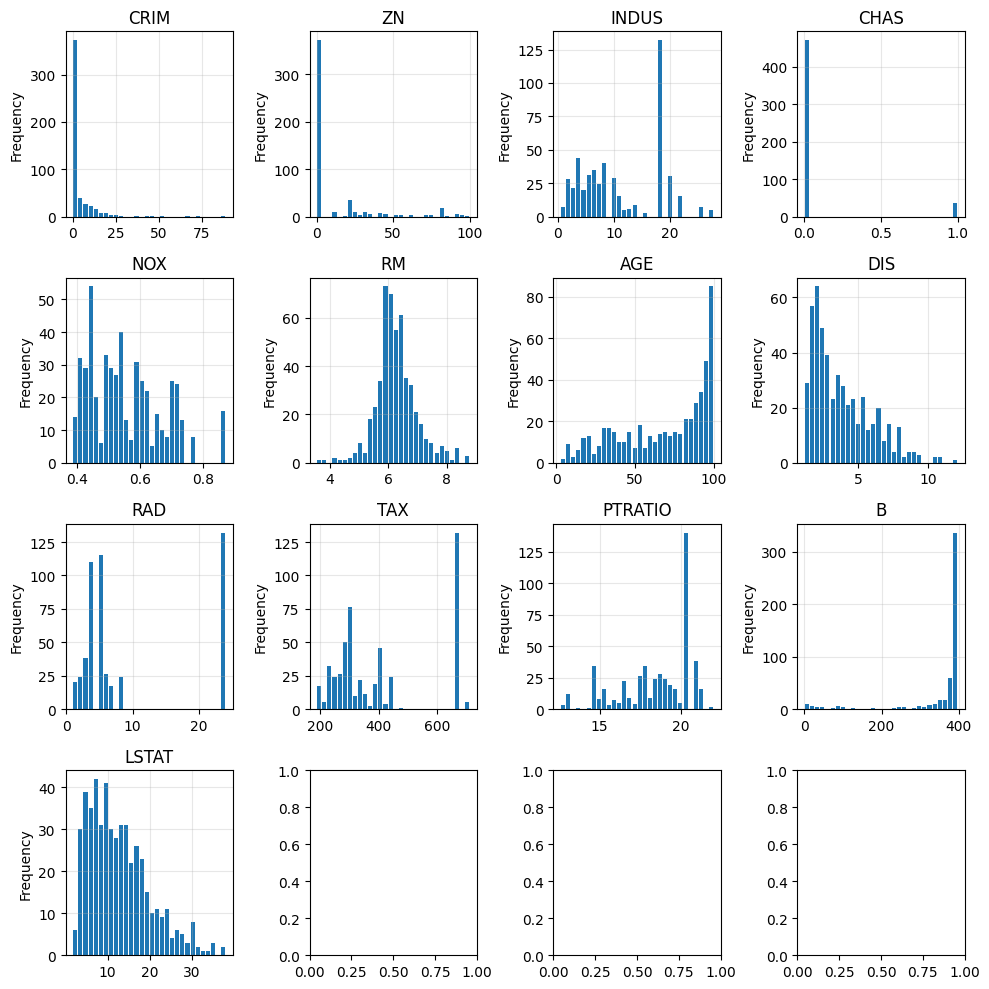

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(len(df.columns[:-2])):
    df[df.columns[i]].plot.hist(ax = axes[i//4][i%4], title = df.columns[i], rwidth=0.8, bins=30)
    axes[i//4][i%4].grid(alpha=0.3)
plt.tight_layout()

<Axes: >

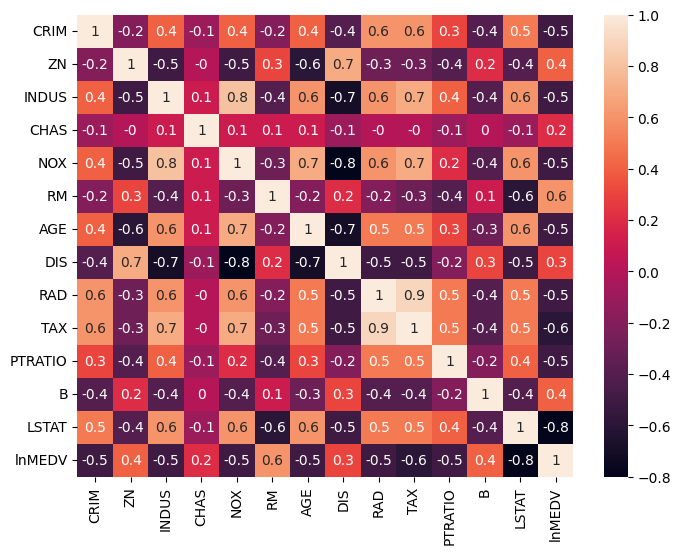

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(round(df[df.columns.drop('MEDV')].corr(),1), annot=True)

train、validation构造

In [9]:
# Split training dataset and validation dataset
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(df.drop(['MEDV'], axis=1), test_size=0.5, random_state=1)

In [10]:
training_set = training_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

In [11]:
# Data explore
# sns.pairplot(df)

In [12]:
from statsmodels.formula.api import ols ,wls
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.diagnostic as smd

In [13]:
# Run simple regression for every X
reg_result = []
reg_resid = {}
reg_fitval = {}
for i in training_set.columns.drop('lnMEDV'):
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    # beta
    beta = reg_model.params.iloc[1]
    # t-value
    tValue = reg_model.tvalues.iloc[1]
    # Durbin-Watson test statiitcs
    dwt = sms.durbin_watson(reg_model.resid)
    # Jarque-Bera test Chi^2 two-tail prob
    jbt = sms.jarque_bera(reg_model.resid)[1]
    # Breusch-Pagan Test p-value
    bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
    reg_result.append([beta, abs(tValue), dwt, jbt, bpt])
    reg_fitval[i] = reg_model.fittedvalues
    reg_resid[i] = reg_model.resid

In [16]:
infl = reg_model.get_influence()
sm_fr = infl.summary_frame()

In [35]:
(sm_fr['hat_diag'].sort_values()>sm_fr['hat_diag'].mean()).mean()

0.31620553359683795

In [36]:
(abs(sm_fr['dffits']).sort_values() > np.sqrt(sm_fr['dffits'].mean())*2).mean()

0.11857707509881422

In [37]:
from scipy.stats import f

In [44]:
f.cdf(0.228, 2, len(sm_fr)-2)

0.20371103919736663

In [41]:
sm_fr['cooks_d'].sort_values()

60    0.000
32    0.000
30    0.000
93    0.000
70    0.000
       ... 
197   0.081
225   0.081
83    0.112
217   0.118
42    0.228
Name: cooks_d, Length: 253, dtype: float64

In [43]:
f.cdf(0.49, 3, 17)

0.3061611431116008

In [48]:
(abs(sm_fr['dfb_LSTAT']).sort_values() > 2/np.sqrt(len(sm_fr['dfb_LSTAT']))).mean()

0.11067193675889328

In [46]:
2/np.sqrt(len(sm_fr['dfb_LSTAT']))

0.1257389226923863

Drop掉t最小的variable：CHAS

In [49]:
pd.set_option('display.float_format', '{:.3f}'.format)
simple_reg_result = pd.DataFrame(reg_result, index=training_set.columns.drop('lnMEDV'), columns=['beta','abs(tValue)','Durbin-Watson test','Jarque-Bera test (pValue)','Breusch-Pagan (pValue)']).sort_values('abs(tValue)', ascending=False)
simple_reg_result

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


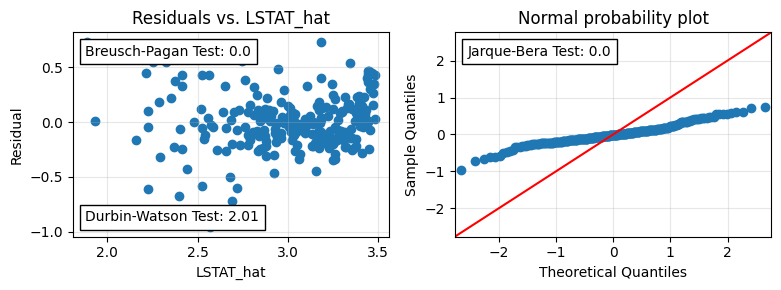

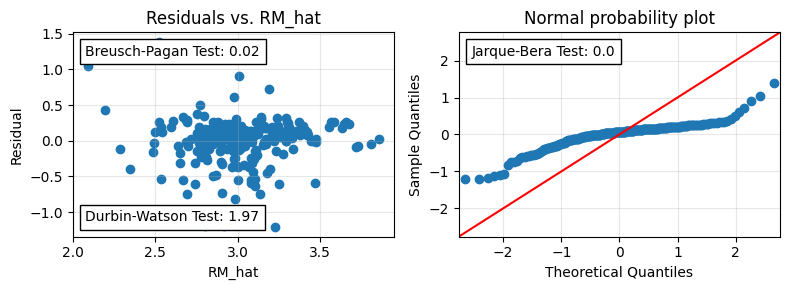

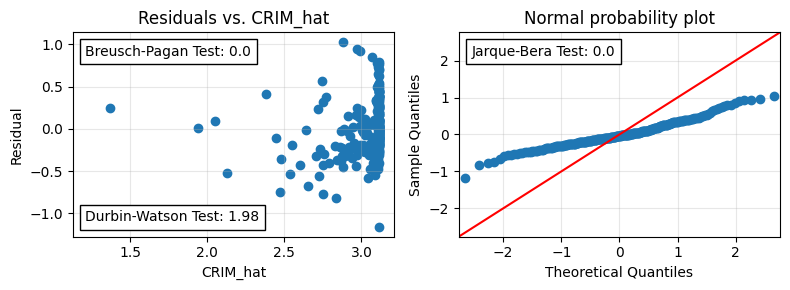

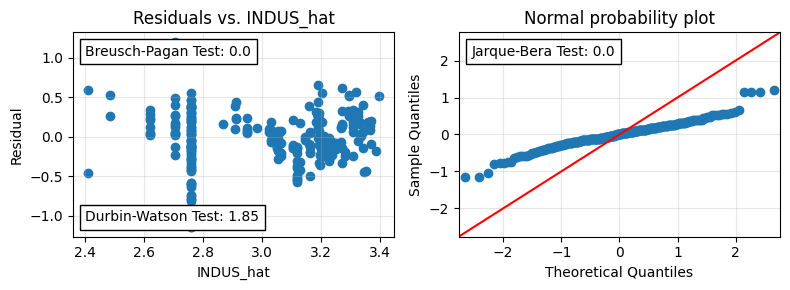

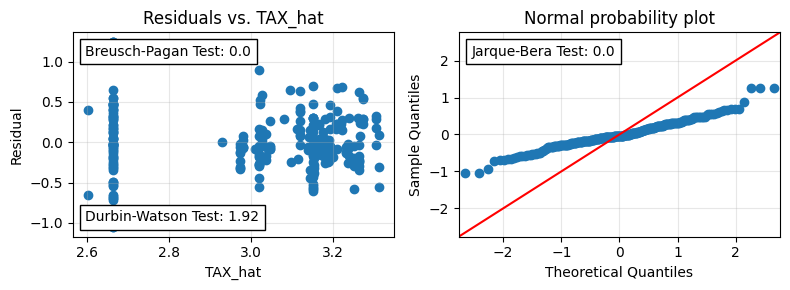

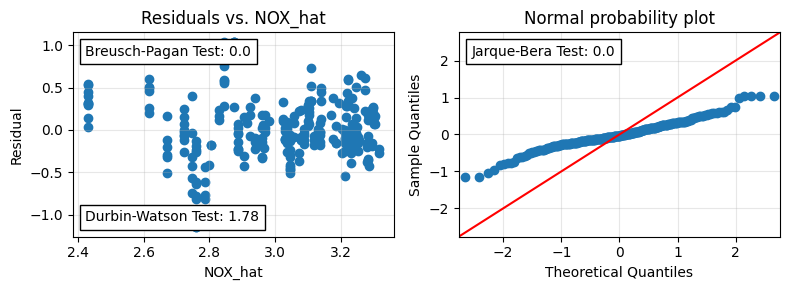

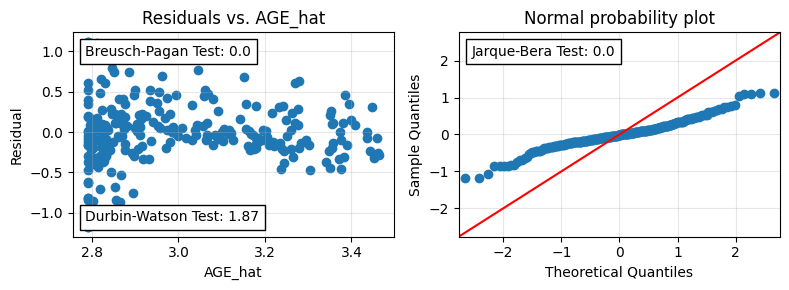

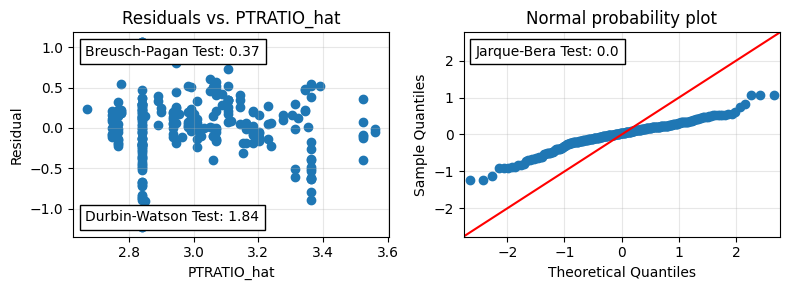

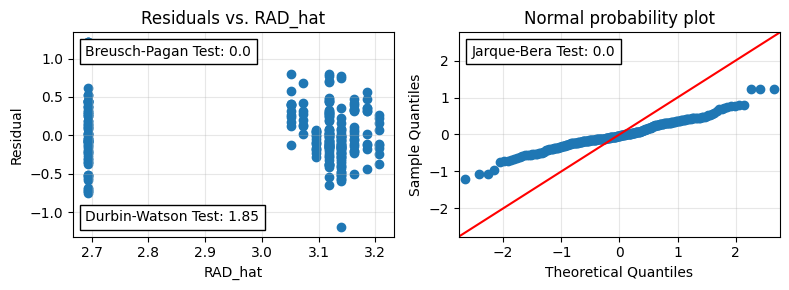

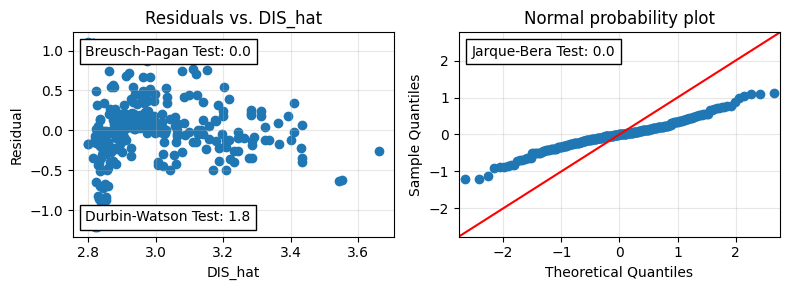

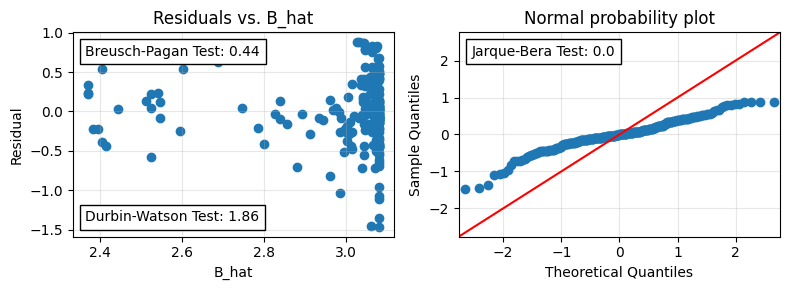

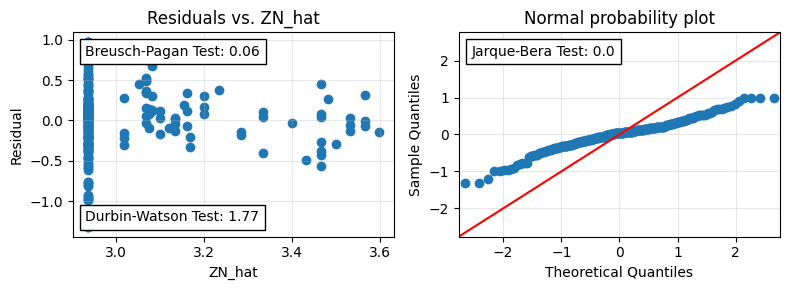

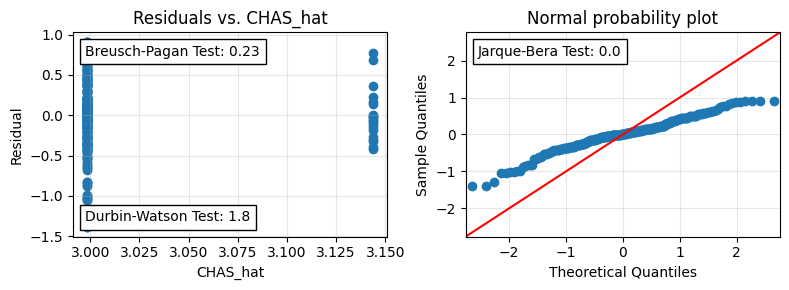

In [50]:
from matplotlib.offsetbox import AnchoredText
for i in simple_reg_result.index:
        fig, axs = plt.subplots(1, 2, figsize=(8,3))

        axs[0].scatter(reg_fitval[i], reg_resid[i])
        axs[0].grid(alpha = 0.3)
        axs[0].set_title('Residuals vs. '+i+'_hat')
        axs[0].set_ylabel('Residual')
        axs[0].set_xlabel(i+'_hat')
        anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(simple_reg_result.loc[i,'Breusch-Pagan (pValue)'],2)), loc=2)
        axs[0].add_artist(anchored_text)
        anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(simple_reg_result.loc[i,'Durbin-Watson test'],2)), loc=3)
        axs[0].add_artist(anchored_text)


        sm.qqplot(reg_resid[i], line="45", ax=axs[1])
        axs[1].grid(alpha = 0.3)
        axs[1].set_title('Normal probability plot')
        anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(simple_reg_result.loc[i,'Jarque-Bera test (pValue)'],2)), loc=2)
        axs[1].add_artist(anchored_text)
        fig.tight_layout()

In [51]:
candidate = simple_reg_result[simple_reg_result['abs(tValue)']>2]
candidate

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


以下为设置partial F test p不大于0.1的criteria，step-wise测试，直到新模型p大于0.1停止

In [54]:
partial_f_test_treshold = 0.05

In [55]:
# stepwise regression processing
X_candidate = candidate.index[1:]
X_candidate_collection = [candidate.index[0]]

while len(X_candidate) > 0:
    add_list = {}
    for i in X_candidate:
        
        syntax_var = str(X_candidate_collection+[i]).replace("[","").replace("]","").replace("'","").replace(","," +")
        reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
        
        hypotheses = '('+i+' = 0)'
        partial_f_test = reg_model.f_test(hypotheses).pvalue
        add_list[i] = partial_f_test
        print("model contains: "+syntax_var)
    add_list = pd.Series(add_list).sort_values()
    print(add_list.iloc[[0]])
    if add_list.iloc[0] < partial_f_test_treshold:
        X_candidate_collection.append(add_list.index[0])
    else:
        break
    # check whether affect previous variables
    syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
    reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
    variables_pValue = reg_model.pvalues[1:]
    delete_var = variables_pValue.where(variables_pValue > partial_f_test_treshold).dropna().index.to_list()
    [X_candidate_collection.remove(delete) for delete in delete_var]

    X_candidate = X_candidate.drop(add_list.index[0])
    

model contains: LSTAT + RM
model contains: LSTAT + CRIM
model contains: LSTAT + INDUS
model contains: LSTAT + TAX
model contains: LSTAT + NOX
model contains: LSTAT + AGE
model contains: LSTAT + PTRATIO
model contains: LSTAT + RAD
model contains: LSTAT + DIS
model contains: LSTAT + B
model contains: LSTAT + ZN
CRIM   0.000
dtype: float64
model contains: LSTAT + CRIM + RM
model contains: LSTAT + CRIM + INDUS
model contains: LSTAT + CRIM + TAX
model contains: LSTAT + CRIM + NOX
model contains: LSTAT + CRIM + AGE
model contains: LSTAT + CRIM + PTRATIO
model contains: LSTAT + CRIM + RAD
model contains: LSTAT + CRIM + DIS
model contains: LSTAT + CRIM + B
model contains: LSTAT + CRIM + ZN
PTRATIO   0.000
dtype: float64
model contains: LSTAT + CRIM + PTRATIO + RM
model contains: LSTAT + CRIM + PTRATIO + INDUS
model contains: LSTAT + CRIM + PTRATIO + TAX
model contains: LSTAT + CRIM + PTRATIO + NOX
model contains: LSTAT + CRIM + PTRATIO + AGE
model contains: LSTAT + CRIM + PTRATIO + RAD
model c

0.057大于0.1 因此停止在4个变量，分别为LSTAT, CRIM, PTRATIO, RM

根據stepwise regression計算最佳的subset為4個變量，因此後續檢測c12取3,4,5個變數，以避免落在local optimal

In [56]:
syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
reg_model_validation = ols('lnMEDV ~ '+ syntax_var, data=validation_set).fit()

In [57]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     183.8
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           6.28e-73
Time:                        10:07:05   Log-Likelihood:                 34.818
No. Observations:                 253   AIC:                            -59.64
Df Residuals:                     248   BIC:                            -41.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3337      0.234     14.255      0.0

检验和图像都发现残差的方差不是恒定的


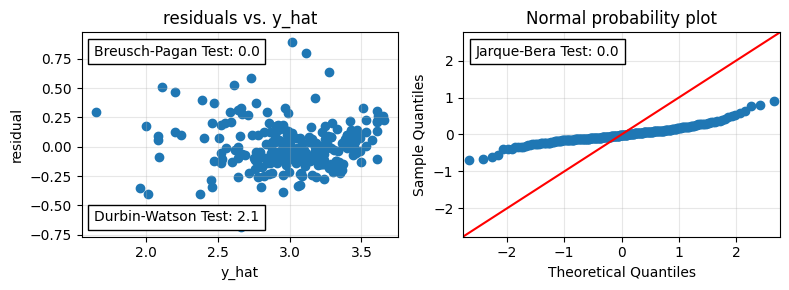

In [72]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(reg_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(reg_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)

sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

Text(0.5, 1.0, 'Residual Distribution')

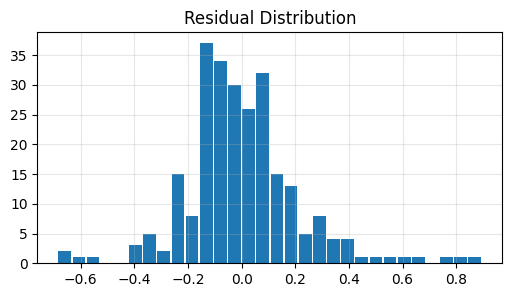

In [73]:
ax1 = reg_model.resid.hist(bins=30, figsize=(6,3), rwidth=0.9)
ax1.grid(alpha = 0.3)
ax1.set_title('Residual Distribution')

<Axes: >

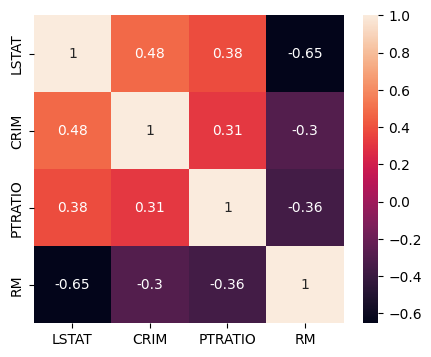

In [58]:
plt.figure(figsize=(5,4))
sns.heatmap(training_set[X_candidate_collection].corr(), annot=True)

In [59]:
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

In [66]:
power_set = combs(candidate.index)[1:]
var3 = [i for i in power_set if len(i) == 3]
var4 = [i for i in power_set if len(i) == 4]
var5 = [i for i in power_set if len(i) == 5]

In [70]:
# total are 1507 combination
all_possible = var3+var4+var5
len(all_possible)

1507

1507

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [48]:
VIF = pd.DataFrame()
VIF['feature']  = X_candidate_collection
VIF['VIF'] = [variance_inflation_factor(training_set[X_candidate_collection].values, i) for i in range(training_set[X_candidate_collection].shape[1])]
VIF

,feature,VIF
0,LSTAT,10.082
1,CRIM,2.305
2,PTRATIO,101.074
3,RM,76.150
4,DIS,15.244
5,NOX,54.360
6,RAD,15.851
7,TAX,60.525
8,ZN,3.654
9,B,21.296


VIF 有大于10的变量，因此model存在共线性的问题

因此之后的model需要用WLS

In [52]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

residual_data_valid = pd.concat([abs(reg_model_validation.resid),reg_model_validation.fittedvalues], axis=1)
residual_data_valid.columns = ['abs_residual', 'y_hat']
residual_model_valid = ols('abs_residual ~ y_hat', data=residual_data_valid).fit()

In [53]:
wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
wls_whole_model_valid = wls('lnMEDV ~ '+ syntax_var, data=validation_set, weights = 1/residual_model_valid.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.800
Model:                            WLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     96.95
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           9.15e-79
Time:                        23:40:55   Log-Likelihood:                 67.438
No. Observations:                 253   AIC:                            -112.9
Df Residuals:                     242   BIC:                            -74.01
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7368      0.288     12.976      0.0

In [54]:
def press_criterion(reg_data, ind_variables, freq):
    press = 0
    for i in range(0, len(reg_data)-freq+1, freq):
        wls_model = wls('lnMEDV ~ '+ind_variables, data=reg_data.drop(range(i,i+freq)), weights = 1/residual_model.fittedvalues.drop(range(i,i+freq))).fit()
        press += ((wls_model.predict(reg_data[ind_variables.split(' + ')].iloc[i:i+freq]).values[0] - reg_data['lnMEDV'][i:i+freq])**2).sum()
    return press

def mallows_cp(reg_data, muliple_variable_list, wls_whole_model, wls_model):
    c = wls_model.ssr/wls_whole_model.mse_resid-(len(reg_data)-2*(len(muliple_variable_list)+1)+1)
    return c
    

以下是基于10个变量模型进行powerset test，由于PRESS的计算时间很长，因此我们先通过C_P和adj R方进行筛选 按照这两个criterion各选出前10哥 再计算这20个model的PRESS

In [55]:
combs(X_candidate_collection)[1:]

[['LSTAT'],
 ['CRIM'],
 ['CRIM', 'LSTAT'],
 ['PTRATIO'],
 ['PTRATIO', 'LSTAT'],
 ['PTRATIO', 'CRIM'],
 ['PTRATIO', 'CRIM', 'LSTAT'],
 ['RM'],
 ['RM', 'LSTAT'],
 ['RM', 'CRIM'],
 ['RM', 'CRIM', 'LSTAT'],
 ['RM', 'PTRATIO'],
 ['RM', 'PTRATIO', 'LSTAT'],
 ['RM', 'PTRATIO', 'CRIM'],
 ['RM', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['DIS'],
 ['DIS', 'LSTAT'],
 ['DIS', 'CRIM'],
 ['DIS', 'CRIM', 'LSTAT'],
 ['DIS', 'PTRATIO'],
 ['DIS', 'PTRATIO', 'LSTAT'],
 ['DIS', 'PTRATIO', 'CRIM'],
 ['DIS', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['DIS', 'RM'],
 ['DIS', 'RM', 'LSTAT'],
 ['DIS', 'RM', 'CRIM'],
 ['DIS', 'RM', 'CRIM', 'LSTAT'],
 ['DIS', 'RM', 'PTRATIO'],
 ['DIS', 'RM', 'PTRATIO', 'LSTAT'],
 ['DIS', 'RM', 'PTRATIO', 'CRIM'],
 ['DIS', 'RM', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['NOX'],
 ['NOX', 'LSTAT'],
 ['NOX', 'CRIM'],
 ['NOX', 'CRIM', 'LSTAT'],
 ['NOX', 'PTRATIO'],
 ['NOX', 'PTRATIO', 'LSTAT'],
 ['NOX', 'PTRATIO', 'CRIM'],
 ['NOX', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['NOX', 'RM'],
 ['NOX', 'RM', 'LSTAT'],
 ['NOX', 'RM', 'CR

In [56]:
powerset_var = combs(X_candidate_collection)[1:]
criterions = []
k = 0
for i in powerset_var:
    ind_var = str(i).replace("'",'').replace("[",'').replace("]",'').replace(",",' +')
    reg_model = ols('lnMEDV ~ '+ind_var, data=training_set).fit()
    
    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()
    try:
        wls_model = wls('lnMEDV ~ '+ind_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
    except:
        p = len(i)
        sse = np.nan
        req = np.nan
        rsq_a = np.nan
        cp = np.nan
        aic = np.nan
        bic = np.nan
        press = np.nan

    
    p = len(i)
    sse = wls_model.ssr
    rsq = wls_model.rsquared
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i, wls_whole_model, wls_model)
    aic = wls_model.aic
    bic = wls_model.bic
    # press = press_criterion(training_set, ind_var, 1)
    press = np.nan
    criterions.append([ind_var, p,sse,rsq,rsq_a,cp,aic,bic,press])
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


76
77
78
79
80
81
82
83
84
85
86
87


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


124
125
126
127
128
129
130
131
132
133
134
135


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


190
191
192
193
194
195
196
197
198
199


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


200
201
202
203
204
205


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


206
207
208
209
210
211
212
213
214
215
216


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


286
287
288
289
290
291
292
293
294
295
296
297
298


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


299
300
301
302
303
304
305
306
307
308
309
310
311
312


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


334
335
336
337
338
339
340
341
342
343
344
345
346
347


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


348
349
350
351
352
353
354
355
356
357
358
359


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


381
382
383
384
385
386
387
388
389
390
391
392
393


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

414
415
416
417
418
419
420
421
422
423
424
425
426


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


445
446
447
448
449
450
451
452
453
454
455


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


474
475
476
477
478
479
480
481
482
483
484
485
486
487


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


546
547
548
549
550
551
552


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


585
586
587
588
589
590
591
592
593


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


594
595
596
597
598
599
600
601
602
603
604
605


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

606
607
608
609
610
611
612
613
614
615
616
617


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

655
656
657
658
659
660
661
662
663
664
665
666
667
668
669


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

670
671
672
673
674
675
676
677
678
679
680
681
682


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


683
684
685
686
687
688
689
690
691
692
693
694
695


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

717
718
719
720
721
722
723
724
725
726
727
728
729
730


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


731
732
733
734
735
736


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


737
738
739
740
741
742
743
744
745
746
747
748


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


785
786
787
788
789
790
791
792
793
794
795
796
797


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


798
799
800
801
802
803
804
805
806
807
808
809


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


829
830
831
832
833
834
835
836
837
838
839
840
841
842


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


860
861
862
863
864
865


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


866
867
868
869
870
871
872
873
874
875


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


876
877
878
879
880
881
882
883
884
885
886
887
888
889


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


908
909
910
911
912


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


913
914
915
916
917
918
919
920
921
922


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

923
924
925
926
927


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


928
929
930
931
932
933
934
935
936
937
938
939


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


956
957
958
959
960
961
962
963
964
965
966
967


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


968
969
970
971
972
973
974
975
976
977


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


978
979
980
981
982
983
984
985
986


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


987
988
989
990


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


991
992
993
994
995
996
997
998
999
1000
1001


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


1002
1003
1004
1005


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


1006
1007
1008
1009
1010
1011
1012
1013
1014
1015


e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
e:\Pycharmprojects\数据挖掘\venv\lib\site-packages\statsmodels\regression\linear_model.py:741: Ru

1016
1017
1018
1019
1020
1021
1022
1023


In [59]:
criterions_df = pd.DataFrame(criterions, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')
criterions_df['No.'] = range(len(criterions))
criterions_df['abs(Cp)'] = abs(criterions_df['p'] - criterions_df['Cp'])

In [60]:
c1 = criterions_df.sort_values('Cp').head(10)
c1

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,No.,abs(Cp)
ind_variables,,,,,,,,,,
ZN + TAX + RAD + NOX + DIS + RM,6,64.433,0.771,0.764,6.947,-89.388,-57.587,NaN,503,0.947
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,NaN,254,0.474
TAX + RAD + NOX + DIS + RM,5,65.117,0.763,0.757,7.570,-83.899,-55.632,NaN,247,2.570
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,NaN,510,0.277
B + ZN + TAX + RAD + NOX + DIS + RM,7,64.397,0.774,0.765,8.810,-90.176,-54.842,NaN,1015,1.810
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,NaN,766,0.147
RAD + NOX + DIS + RM,4,66.172,0.758,0.752,9.612,-79.018,-54.285,NaN,119,5.612
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO,7,64.678,0.789,0.782,9.887,-100.458,-68.658,NaN,507,2.887
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,NaN,1022,0.000


In [ ]:
c2 = criterions_df.sort_values('adj_R2', ascending=False).head(10)
c2

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,No.,abs(Cp)
ind_variables,,,,,,,,,,
B + TAX + RAD + NOX + DIS + RM,6,100.653,0.918,0.916,145.762,11.825,36.559,NaN,759,139.762
TAX + RAD + DIS + RM + PTRATIO + CRIM,6,83.751,0.902,0.899,80.983,-31.456,-6.723,NaN,221,74.983
B + NOX + DIS + RM,4,101.219,0.866,0.864,143.934,34.072,51.739,NaN,567,139.934
NOX + DIS + RM + PTRATIO,4,96.445,0.863,0.861,125.636,8.313,25.980,NaN,59,121.636
B + RAD + NOX + DIS + RM + PTRATIO,6,91.831,0.864,0.861,111.951,-14.423,10.311,NaN,635,105.951
B + ZN + RAD + NOX + DIS + RM + PTRATIO,7,90.928,0.853,0.849,110.490,-13.504,14.764,NaN,891,103.490
ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM,7,82.456,0.847,0.843,78.021,-33.145,-4.878,NaN,477,71.021
ZN + TAX + DIS + RM + CRIM,5,82.657,0.844,0.841,74.793,-26.554,-5.354,NaN,409,69.793
B + ZN + TAX + NOX + DIS + RM + CRIM,7,81.403,0.842,0.838,73.987,-31.796,-3.529,NaN,953,66.987


计算20个model的PRESS

In [ ]:
total=c1.index.append(c2.index)

In [ ]:
press_list = []
for i in total:
    press_list.append(press_criterion(training_set, i, 1))
    print(i)

ZN + TAX + RAD + NOX + DIS + RM
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
TAX + RAD + NOX + DIS + RM
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
B + ZN + TAX + RAD + NOX + DIS + RM
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
RAD + NOX + DIS + RM
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
B + TAX + RAD + NOX + DIS + RM
TAX + RAD + DIS + RM + PTRATIO + CRIM
B + NOX + DIS + RM
NOX + DIS + RM + PTRATIO
B + RAD + NOX + DIS + RM + PTRATIO
B + ZN + RAD + NOX + DIS + RM + PTRATIO
ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM
ZN + TAX + DIS + RM + CRIM
B + ZN + TAX + NOX + DIS + RM + CRIM
B + ZN + RAD + NOX + RM + PTRATIO


In [ ]:
c1['PRESS'] = press_list[:10]
criterions_df.loc[c1.index,"PRESS"] = press_list[:10]
criterions_df.loc[c2.index,"PRESS"] = press_list[10:]
criterions_df.sort_values('abs(Cp)').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,No.,abs(Cp)
ind_variables,,,,,,,,,,
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,11.252,1022,0.000
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,11.360,766,0.147
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,11.152,510,0.277
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,11.264,254,0.474
ZN + TAX + RAD + NOX + DIS + RM,6,64.433,0.771,0.764,6.947,-89.388,-57.587,20.467,503,0.947
B + ZN + TAX + RAD + NOX + DIS + RM,7,64.397,0.774,0.765,8.810,-90.176,-54.842,19.921,1015,1.810
TAX + RAD + NOX + DIS + RM,5,65.117,0.763,0.757,7.570,-83.899,-55.632,20.795,247,2.570
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO,7,64.678,0.789,0.782,9.887,-100.458,-68.658,19.380,507,2.887
ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT,8,64.433,0.771,0.764,10.947,-89.388,-57.587,NaN,502,2.947


In [ ]:
criterions_df.sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,No.,abs(Cp)
ind_variables,,,,,,,,,,
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,11.152,510,0.277
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,11.252,1022,0.000
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,11.264,254,0.474
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,11.360,766,0.147
RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,7,64.809,0.784,0.778,10.386,-102.639,-74.372,11.391,126,3.386
ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM,7,82.456,0.847,0.843,78.021,-33.145,-4.878,17.385,477,71.021
TAX + RAD + DIS + RM + PTRATIO + CRIM,6,83.751,0.902,0.899,80.983,-31.456,-6.723,17.494,221,74.983
B + ZN + TAX + NOX + DIS + RM + CRIM,7,81.403,0.842,0.838,73.987,-31.796,-3.529,17.736,953,66.987
ZN + TAX + DIS + RM + CRIM,5,82.657,0.844,0.841,74.793,-26.554,-5.354,18.208,409,69.793


根据PRESS和C_P选取三个model,每次删除VIF最大的变量

In [ ]:
Top2Model = []

In [ ]:
VIF = pd.DataFrame()
name = criterions_df[criterions_df['No.']==510].index.to_list()[0].split(' + ')
name.remove('PTRATIO')
name.remove('NOX')
name.remove('TAX')
name.remove('RM')
VIF['feature']  = name
VIF['VIF'] = [variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])]
VIF

,feature,VIF
0,ZN,2.467
1,RAD,3.685
2,DIS,4.284
3,CRIM,2.136
4,LSTAT,4.215


In [ ]:
Top2Model.append(str(VIF['feature'].values).replace(' '," + ").replace("'","").replace("[","").replace("]",""))

In [ ]:
VIF = pd.DataFrame()
name = criterions_df[criterions_df['No.']==254].index.to_list()[0].split(' + ')
name.remove('PTRATIO')
name.remove('NOX')
name.remove('TAX')
name.remove('RM')
VIF['feature']  = name
VIF['VIF'] = [variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])]
VIF

,feature,VIF
0,RAD,3.659
1,DIS,1.835
2,CRIM,2.078
3,LSTAT,3.735


In [ ]:
Top2Model.append(str(VIF['feature'].values).replace(' '," + ").replace("'","").replace("[","").replace("]",""))

In [ ]:
VIF = pd.DataFrame()
name = criterions_df[criterions_df['No.']==766].index.to_list()[0].split(' + ')
name.remove('PTRATIO')
name.remove('NOX')
name.remove('TAX')
name.remove('RM')
VIF['feature']  = name
VIF['VIF'] = [variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])]
VIF
# 由于B这个变量的VIF 接近10所以也删除这个变量

,feature,VIF
0,B,9.079
1,RAD,3.870
2,DIS,4.883
3,CRIM,2.256
4,LSTAT,5.168


第三个model的变量与第二个一样 因此我们将两个model进行验证集和训练集的比对

In [ ]:
Top2Model = np.array(Top2Model)

In [ ]:
col = Top2Model.repeat(2)
idx = ['p'] + [i+'_b' for i in X_candidate_collection] + [i+'_std(b)' for i in X_candidate_collection] + ['SSE', 'PRESS', 'Cp', 'MSE'	,'MSPR', 'adj_R2']

assessment_table = pd.DataFrame(index=idx, columns=[j+' (Training)' if i%2==0 else j+' (Validation)' for i,j in enumerate(col)])
for i in Top2Model:
    # insample
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=training_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]

    sse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model, wls_model)

    press = press_criterion(training_set, i, 1)
    mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).sum()/(wls_model.df_resid)

    assessment_table.loc['p',i+' (Training)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Training)'] = beta
    assessment_table.loc[beta_std.index,i+' (Training)'] = beta_std
    assessment_table.loc['SSE',i+' (Training)'] = sse
    assessment_table.loc['PRESS',i+' (Training)'] = press
    assessment_table.loc['Cp',i+' (Training)'] = cp
    assessment_table.loc['MSE',i+' (Training)'] = mse
    assessment_table.loc['MSPR',i+' (Training)'] = mspr
    assessment_table.loc['adj_R2',i+' (Training)'] = rsq_a


    # out of sample
    reg_model = ols('lnMEDV ~ '+i, data=validation_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=validation_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]
    
    sse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model_valid, wls_model)

    press = press_criterion(training_set, i, 1)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).mean()

    assessment_table.loc['p',i+' (Validation)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Validation)'] = beta
    assessment_table.loc[beta_std.index,i+' (Validation)'] = beta_std
    assessment_table.loc['SSE',i+' (Validation)'] = sse
    assessment_table.loc['PRESS',i+' (Validation)'] = press
    assessment_table.loc['Cp',i+' (Validation)'] = cp
    assessment_table.loc['MSE',i+' (Validation)'] = mse

    assessment_table.loc['adj_R2',i+' (Validation)'] = rsq_a

In [ ]:
assessment_table.dropna(how="all")

,ZN + RAD + DIS + CRIM + LSTAT (Training),ZN + RAD + DIS + CRIM + LSTAT (Validation),RAD + DIS + CRIM + LSTAT (Training),RAD + DIS + CRIM + LSTAT (Validation)
p,5,5,4,4
LSTAT_b,-0.043,-0.046,-0.043,-0.048
CRIM_b,-0.013,-0.008,-0.012,-0.007
DIS_b,-0.043,-0.057,-0.016,-0.042
RAD_b,0.001,-0.004,0.001,-0.004
ZN_b,0.003,0.002,NaN,NaN
LSTAT_std(b),0.002,0.003,0.002,0.003
CRIM_std(b),0.002,0.003,0.002,0.003
DIS_std(b),0.010,0.009,0.008,0.008
RAD_std(b),0.002,0.002,0.002,0.002


发现两个model的RAD变量的beta在train和validation的符号不一样因此两个model都不能用，调整Partial Ftest p =0.05

In [ ]:
partial_f_test_treshold = 0.05

In [ ]:
# stepwise regression processing
X_candidate = candidate.index[1:]
X_candidate_collection = [candidate.index[0]]

while len(X_candidate) > 0:
    add_list = {}
    for i in X_candidate:
        
        syntax_var = str(X_candidate_collection+[i]).replace("[","").replace("]","").replace("'","").replace(","," +")
        reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
        
        hypotheses = '('+i+' = 0)'
        partial_f_test = reg_model.f_test(hypotheses).pvalue
        add_list[i] = partial_f_test
        print("model contains: "+syntax_var)
    add_list = pd.Series(add_list).sort_values()
    print(add_list.iloc[[0]])
    if add_list.iloc[0] < partial_f_test_treshold:
        X_candidate_collection.append(add_list.index[0])
    else:
        break
    # check whether affect previous variables
    syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
    reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
    variables_pValue = reg_model.pvalues[1:]
    delete_var = variables_pValue.where(variables_pValue > partial_f_test_treshold).dropna().index.to_list()
    [X_candidate_collection.remove(delete) for delete in delete_var]

    X_candidate = X_candidate.drop(add_list.index[0])
    

model contains: LSTAT + RM
model contains: LSTAT + CRIM
model contains: LSTAT + INDUS
model contains: LSTAT + TAX
model contains: LSTAT + NOX
model contains: LSTAT + AGE
model contains: LSTAT + PTRATIO
model contains: LSTAT + RAD
model contains: LSTAT + DIS
model contains: LSTAT + B
model contains: LSTAT + ZN
CRIM   0.000
dtype: float64
model contains: LSTAT + CRIM + RM
model contains: LSTAT + CRIM + INDUS
model contains: LSTAT + CRIM + TAX
model contains: LSTAT + CRIM + NOX
model contains: LSTAT + CRIM + AGE
model contains: LSTAT + CRIM + PTRATIO
model contains: LSTAT + CRIM + RAD
model contains: LSTAT + CRIM + DIS
model contains: LSTAT + CRIM + B
model contains: LSTAT + CRIM + ZN
PTRATIO   0.000
dtype: float64
model contains: LSTAT + CRIM + PTRATIO + RM
model contains: LSTAT + CRIM + PTRATIO + INDUS
model contains: LSTAT + CRIM + PTRATIO + TAX
model contains: LSTAT + CRIM + PTRATIO + NOX
model contains: LSTAT + CRIM + PTRATIO + AGE
model contains: LSTAT + CRIM + PTRATIO + RAD
model c

最终选出的model为四变量：LSTAT + CRIM + PTRATIO + RM

In [ ]:
syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
reg_model_validation = ols('lnMEDV ~ '+ syntax_var, data=validation_set).fit()


In [ ]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     183.8
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           6.28e-73
Time:                        22:31:41   Log-Likelihood:                 34.818
No. Observations:                 253   AIC:                            -59.64
Df Residuals:                     248   BIC:                            -41.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3337      0.234     14.255      0.0

In [ ]:
print(reg_model_validation.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     175.5
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           4.40e-71
Time:                        22:31:44   Log-Likelihood:                 45.892
No. Observations:                 253   AIC:                            -81.78
Df Residuals:                     248   BIC:                            -64.12
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3220      0.219     15.161      0.0

<AxesSubplot:>

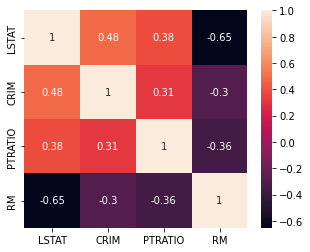

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(training_set[X_candidate_collection].corr(), annot=True)

In [ ]:
VIF = pd.DataFrame()
VIF['feature']  = X_candidate_collection
VIF['VIF'] = [variance_inflation_factor(training_set[X_candidate_collection].values, i) for i in range(training_set[X_candidate_collection].shape[1])]
VIF

,feature,VIF
0,LSTAT,6.938
1,CRIM,1.556
2,PTRATIO,55.012
3,RM,38.266


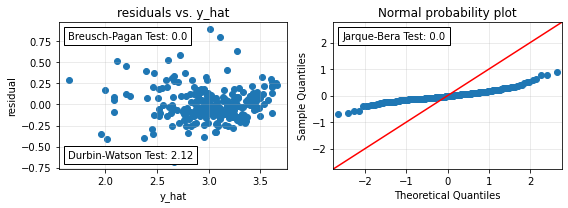

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)

sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

Text(0.5, 1.0, 'Residual Distribution')

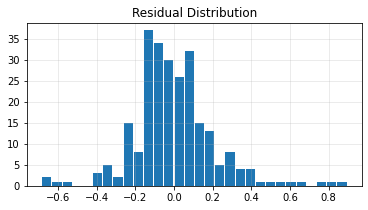

In [ ]:
ax1 = reg_model.resid.hist(bins=30, figsize=(6,3), rwidth=0.9)
ax1.grid(alpha = 0.3)
ax1.set_title('Residual Distribution')

In [ ]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

residual_data_valid = pd.concat([abs(reg_model_validation.resid),reg_model_validation.fittedvalues], axis=1)
residual_data_valid.columns = ['abs_residual', 'y_hat']
residual_model_valid = ols('abs_residual ~ y_hat', data=residual_data_valid).fit()

In [ ]:
wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
wls_whole_model_valid = wls('lnMEDV ~ '+ syntax_var, data=validation_set, weights = 1/residual_model_valid.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.771
Model:                            WLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     209.2
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           3.20e-78
Time:                        22:49:55   Log-Likelihood:                 51.680
No. Observations:                 253   AIC:                            -93.36
Df Residuals:                     248   BIC:                            -75.69
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9597      0.217     13.625      0.0

以下是基于四变量模型进行powerset test，选择标准为Cp、PRESS

In [ ]:
combs(X_candidate_collection)[1:]

[['LSTAT'],
 ['CRIM'],
 ['CRIM', 'LSTAT'],
 ['PTRATIO'],
 ['PTRATIO', 'LSTAT'],
 ['PTRATIO', 'CRIM'],
 ['PTRATIO', 'CRIM', 'LSTAT'],
 ['RM'],
 ['RM', 'LSTAT'],
 ['RM', 'CRIM'],
 ['RM', 'CRIM', 'LSTAT'],
 ['RM', 'PTRATIO'],
 ['RM', 'PTRATIO', 'LSTAT'],
 ['RM', 'PTRATIO', 'CRIM'],
 ['RM', 'PTRATIO', 'CRIM', 'LSTAT']]

In [ ]:
powerset_var = combs(X_candidate_collection)[1:]
criterions = []
k = 0
for i in powerset_var:
    ind_var = str(i).replace("'",'').replace("[",'').replace("]",'').replace(",",' +')
    reg_model = ols('lnMEDV ~ '+ind_var, data=training_set).fit()
    
    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()
    try:
        wls_model = wls('lnMEDV ~ '+ind_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
    except:
        p = len(i)
        sse = np.nan
        req = np.nan
        rsq_a = np.nan
        cp = np.nan
        aic = np.nan
        bic = np.nan
        press = np.nan

    
    p = len(i)
    sse = wls_model.ssr
    rsq = wls_model.rsquared
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i, wls_whole_model, wls_model)
    aic = wls_model.aic
    bic = wls_model.bic
    press = press_criterion(training_set, ind_var, 1)
    criterions.append([ind_var, p,sse,rsq,rsq_a,cp,aic,bic,press])
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
criterions_df = pd.DataFrame(criterions, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')

In [ ]:
criterions_df['abs(Cp)'] = abs(criterions_df['p'] - criterions_df['Cp'])
criterions_df.sort_values('abs(Cp)').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp)
ind_variables,,,,,,,,,
RM + PTRATIO + CRIM + LSTAT,4,67.392,0.771,0.768,4.000,-93.359,-75.693,12.253,0.000
RM + CRIM + LSTAT,3,68.402,0.750,0.747,5.714,-75.886,-61.752,13.128,2.714
PTRATIO + CRIM + LSTAT,3,71.058,0.724,0.721,15.488,-53.359,-39.226,12.578,12.488
RM + PTRATIO + LSTAT,3,72.585,0.762,0.759,21.109,-68.917,-54.783,13.947,18.109
CRIM + LSTAT,2,73.239,0.694,0.692,21.516,-32.134,-21.533,13.670,19.516
RM + LSTAT,2,75.392,0.741,0.739,29.439,-49.527,-38.926,15.368,27.439
PTRATIO + LSTAT,2,75.764,0.703,0.700,30.808,-31.857,-21.257,14.186,28.808
LSTAT,1,79.849,0.666,0.664,43.840,-7.565,-0.499,15.858,42.840
RM + PTRATIO + CRIM,3,86.881,0.733,0.730,73.719,-7.145,6.988,18.254,70.719


In [ ]:
criterions_df.sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp)
ind_variables,,,,,,,,,
RM + PTRATIO + CRIM + LSTAT,4,67.392,0.771,0.768,4.000,-93.359,-75.693,12.253,0.000
PTRATIO + CRIM + LSTAT,3,71.058,0.724,0.721,15.488,-53.359,-39.226,12.578,12.488
RM + CRIM + LSTAT,3,68.402,0.750,0.747,5.714,-75.886,-61.752,13.128,2.714
CRIM + LSTAT,2,73.239,0.694,0.692,21.516,-32.134,-21.533,13.670,19.516
RM + PTRATIO + LSTAT,3,72.585,0.762,0.759,21.109,-68.917,-54.783,13.947,18.109
PTRATIO + LSTAT,2,75.764,0.703,0.700,30.808,-31.857,-21.257,14.186,28.808
RM + LSTAT,2,75.392,0.741,0.739,29.439,-49.527,-38.926,15.368,27.439
LSTAT,1,79.849,0.666,0.664,43.840,-7.565,-0.499,15.858,42.840
RM + PTRATIO + CRIM,3,86.881,0.733,0.730,73.719,-7.145,6.988,18.254,70.719


最终我们得到最优的三个模型分别为：
RM + CRIM + LSTAT，PTRATIO + CRIM + LSTAT，RM + CRIM + LSTAT

以下是对三模型进行train、validation的比较

In [ ]:
Top3Model = criterions_df.sort_values('abs(Cp)').index[:3].values
col = Top3Model.repeat(2)
idx = ['p'] + [i+'_b' for i in X_candidate_collection] + [i+'_std(b)' for i in X_candidate_collection] + ['SSE', 'PRESS', 'Cp', 'MSE'	,'MSPR', 'adj_R2']

assessment_table = pd.DataFrame(index=idx, columns=[j+' (Training)' if i%2==0 else j+' (Validation)' for i,j in enumerate(col)])
for i in Top3Model:
    # insample
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=training_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]

    sse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model, wls_model)

    press = press_criterion(training_set, i, 1)
    mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).sum()/(wls_model.df_resid)

    assessment_table.loc['p',i+' (Training)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Training)'] = beta
    assessment_table.loc[beta_std.index,i+' (Training)'] = beta_std
    assessment_table.loc['SSE',i+' (Training)'] = sse
    assessment_table.loc['PRESS',i+' (Training)'] = press
    assessment_table.loc['Cp',i+' (Training)'] = cp
    assessment_table.loc['MSE',i+' (Training)'] = mse
    assessment_table.loc['MSPR',i+' (Training)'] = mspr
    assessment_table.loc['adj_R2',i+' (Training)'] = rsq_a


    # out of sample
    reg_model = ols('lnMEDV ~ '+i, data=validation_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=validation_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]
    
    sse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model_valid, wls_model)

    press = press_criterion(training_set, i, 1)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).mean()

    assessment_table.loc['p',i+' (Validation)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Validation)'] = beta
    assessment_table.loc[beta_std.index,i+' (Validation)'] = beta_std
    assessment_table.loc['SSE',i+' (Validation)'] = sse
    assessment_table.loc['PRESS',i+' (Validation)'] = press
    assessment_table.loc['Cp',i+' (Validation)'] = cp
    assessment_table.loc['MSE',i+' (Validation)'] = mse

    assessment_table.loc['adj_R2',i+' (Validation)'] = rsq_a

In [ ]:
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.705
Model:                            WLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     198.5
Date:                Thu, 26 Oct 2023   Prob (F-statistic):           9.75e-66
Time:                        22:55:44   Log-Likelihood:                 31.262
No. Observations:                 253   AIC:                            -54.52
Df Residuals:                     249   BIC:                            -40.39
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3736      0.120     36.451      0.0

得到table，发现模型效果较好（符号相同且数值相近）

In [ ]:
assessment_table

,RM + PTRATIO + CRIM + LSTAT (Training),RM + PTRATIO + CRIM + LSTAT (Validation),RM + CRIM + LSTAT (Training),RM + CRIM + LSTAT (Validation),PTRATIO + CRIM + LSTAT (Training),PTRATIO + CRIM + LSTAT (Validation)
p,4,4,3,3,3,3
LSTAT_b,-0.029,-0.031,-0.031,-0.033,-0.037,-0.039
CRIM_b,-0.009,-0.008,-0.010,-0.010,-0.009,-0.006
PTRATIO_b,-0.027,-0.035,NaN,NaN,-0.034,-0.045
RM_b,0.157,0.160,0.176,0.188,NaN,NaN
LSTAT_std(b),0.003,0.003,0.003,0.003,0.002,0.002
CRIM_std(b),0.002,0.002,0.002,0.002,0.002,0.002
PTRATIO_std(b),0.006,0.006,NaN,NaN,0.007,0.007
RM_std(b),0.023,0.021,0.024,0.022,NaN,NaN
SSE,11.507,10.407,12.413,11.684,12.028,11.615


以下是三模型的VIF分析，需要让所有variable的VIF均小于10

In [ ]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[0].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[0].split(' + ')].values, i) for i in range(training_set[Top3Model[0].split(' + ')].shape[1])]
VIF

,feature,VIF
0,RM,38.266
1,PTRATIO,55.012
2,CRIM,1.556
3,LSTAT,6.938


In [ ]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[1].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[1].split(' + ')].values, i) for i in range(training_set[Top3Model[1].split(' + ')].shape[1])]
VIF

,feature,VIF
0,RM,3.416
1,CRIM,1.543
2,LSTAT,4.335


In [ ]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[2].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[2].split(' + ')].values, i) for i in range(training_set[Top3Model[2].split(' + ')].shape[1])]
VIF

,feature,VIF
0,PTRATIO,4.910
1,CRIM,1.520
2,LSTAT,5.869


最终通过比较VIF，我们认为RM + CRIM + LSTAT为最优模型